# Compare LINEAR and ZTF light curves

### Perform statistical tests and visual analysis to seek evidence for the Blazhko effect:

1) read LINEAR data

2) pick a star using LINEAR ID

3) retrieve ZTF gri data 

4) compute periods using separately LINEAR and ZTF data (gri average for the latter)

5) compute the mean period 

6) compare periods from 4) and 5)

7) compare light curve amplitudes and shapes from 4) and 5)

In [6]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [7]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from ztfquery import lightcurve
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

## some helper routines and wrappers...

In [8]:
def getCoordinatesFromLINEARid(tbl, id0):
    return tbl[tbl['ID'].astype(str)==id0]['ra'][0], tbl[tbl['ID'].astype(str)==id0]['dec'][0]

# retrieve ZTF data for a single object specified by (RA, Dec)
def getZTFlightcurve(ra, dec, radius=3.0):
    # matching radius is given in arcsec
    try:
       lcq = lightcurve.LCQuery()
       res = lcq.from_position(ra, dec, radius)
       ZTFdata = res.data # this is basically a DataFrame then
       # M. Graham recommends to get rid of obvious spurious points
       ZTFdata = ZTFdata.loc[ZTFdata['catflags'] < 32768]
    except Exception as e:
       print(e)
    return ZTFdata

# a little helper: sort array a, and reorder b, c, too. 
def sort3arr(a, b, c):
    ind = np.argsort(a)
    return a[ind], b[ind], c[ind]

def sigG(x):
    return 0.741*(np.percentile(x,75)-np.percentile(x,25))

In [9]:
# wrapper around LombScargle: given light curve data (time, mag, magErr)
# compute period using nterms Fourier terms
# return best period and power spectrum: LSpower(frequency) is lsPS=True
# note: period (days) = 1. / frequency
def doPeriodsOrig(time, mag, magErr, nterms, lsPS=False, nyquist=300):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        if (1):
            frequency, power = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        else:
            frequency = np.arange(0.4, 40, 0.2e-04)
            power = ls.power(frequency)  
        period = 1. / frequency # calculating the periods
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'

# similar to doPeriodsOrig(), but first try with auto frequency grid
# and then "zoom-in" around the highest LS power peak 
def doPeriods(time, mag, magErr, nterms, lsPS=False, nyquist=100, freqFac=1.003):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        best_freq = frequencyAuto[np.argmax(powerAuto)]
        frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'

    
# further wrapping a few steps to average ZTF periods   
def getZTFperiod(ZTFdata, nterms, ZTFbands=['zg', 'zr', 'zi'], lsPS=False, nyquist=300, orig=False):
    try:
        ZTFperiods = []
        for b in ZTFbands:
            BandData = ZTFdata.loc[ZTFdata['filtercode'] == b]
            timeZ = BandData['mjd']
            magZ = BandData['mag']
            magErrZ = BandData['magerr']
            if lsPS:
                try:
                    if (orig):
                        ZTFperiod, Zfreq, Zpow = doPeriodsOrig(timeZ, magZ, magErrZ, nterms, lsPS=lsPS)
                    else:
                        ZTFperiod, Zfreq, Zpow = doPeriods(timeZ, magZ, magErrZ, nterms, lsPS=lsPS)
                    ZTFperiods.append(ZTFperiod)
                except:
                    ZTFperiod = -9.99
                    print('failed for band', b, 'Ndata=', np.size(timeZ))
            else:
                ZTFperiods.append(doPeriods(timeZ, magZ, magErrZ, nterms))
        ZTFbestPeriod = np.median(ZTFperiods)
        if lsPS:
            return ZTFbestPeriod, Zfreq, Zpow
        else:
            return ZTFbestPeriod
    except:
        print('failed: error in getZTFperiod') 
        return 'Error in getZTFperiod'

In [10]:
# given (time, mag, magErr) data, and some period P, 
# return various results of light curve analysis:
# 
def LCanalysisFromP(time, mag, magErr, P, ntermsModels):
    LCanalysisResults = {}
    # first compute best-fit models for given period
    mtf = MultiTermFit(2*np.pi/P, ntermsModels)
    mtf.fit(time, mag, magErr)
    a, b, c = mtf.predict(1000, return_phased_times=True, adjust_offset=False)
    LCanalysisResults['modelPhaseGrid'] = a
    LCanalysisResults['modelFit'] = b
    LCanalysisResults['dataPhasedTime']= c
    # light curve template normalization: mag = A * t(phi) + mmax, where
    # phi is phase, t is template, A is amplitude and mmax is the magnitude at 
    #       maximum light (note: numerically it is the minimum value of mag)
    # also: we are using models for computing amplitude and mmax to avoid noise in data
    A = np.max(b) - np.min(b) 
    mmax = np.min(b) 
    LCanalysisResults['A'] = A
    LCanalysisResults['mmax'] = mmax
    LCanalysisResults['modTemplate'] = (b - mmax)/A 
    LCanalysisResults['dataTemplate'] = (mag - mmax)/A 
    LCanalysisResults['dataTemplateErr'] = magErr/A 
    # for chi2, first interpolate model fit to phases of data values
    modelFit2data = np.interp(c, a, LCanalysisResults['modTemplate'])
    LCanalysisResults['modelFit2data'] = modelFit2data 
    delmag = LCanalysisResults['dataTemplate'] - modelFit2data
    LCanalysisResults['rms'] = sigG(delmag)
    LCanalysisResults['chi'] = delmag/LCanalysisResults['dataTemplateErr']
    LCanalysisResults['chi2dof'] = np.sum(LCanalysisResults['chi']**2)/np.size(LCanalysisResults['chi'])
    LCanalysisResults['chi2dofR'] = sigG(LCanalysisResults['chi'])
    return LCanalysisResults 

In [42]:
# L1 = LINEAR_Plinear
# L2 = LINEAR_Pmean
# Z1 = ZTF_Pztf
# Z2 = ZTF_Pmean
# 
def makeLCplot4(L1, L2, Z1, Z2, plotrootname='LCplot4', plotSave=False):
    fig, axs = plt.subplots(2,2, figsize=(14,10))  

    ### LINEAR plots
    ## TOP LEFT: with best-fit LINEAR period
    axs[0,0].set(xlabel='data phased with best-fit LINEAR period', ylabel='LINEAR normalized light curve')
    axs[0,0].set_xlim(-0.1, 1.1)
    axs[0,0].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
    axs[0,0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Plinear
    axs[0,0].plot(L1['modelPhaseGrid'], L1['modTemplate'], 'black', markeredgecolor='black', lw=2, fillstyle='top', linestyle='solid')
    # fit for mean period
    axs[0,0].plot(L2['modelPhaseGrid'], L2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')

    ## TOP RIGHT: with the mean period
    axs[0,1].set(xlabel='data phased with the mean period', ylabel='LINEAR normalized light curve')
    axs[0,1].set_xlim(-0.1, 1.1)
    axs[0,1].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
    axs[0,1].errorbar(xx, yy, zz, fmt='.r', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for mean period
    axs[0,1].plot(L2['modelPhaseGrid'], L2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')
    
    
    ### ZTF plots
    ## BOTTOM LEFT: with best-fit ZTF period
    axs[1,0].set(xlabel='data phased with best-fit ZTF period', ylabel='ZTF normalized light curve')
    axs[1,0].set_xlim(-0.1, 1.1)
    axs[1,0].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(Z1['dataPhasedTime'], np.array(Z1['dataTemplate']), np.array(Z1['dataTemplateErr']))
    axs[1,0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Pztf
    axs[1,0].plot(Z1['modelPhaseGrid'], Z1['modTemplate'], 'black', markeredgecolor='black', lw=2, fillstyle='top', linestyle='solid')
    # fit for mean period
    axs[1,0].plot(Z2['modelPhaseGrid'], Z2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')

    ## BOTTOM RIGHT: with the mean period
    axs[1,1].set(xlabel='data phased with the mean period', ylabel='ZTF normalized light curve')
    axs[1,1].set_xlim(-0.1, 1.1)
    axs[1,1].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(Z2['dataPhasedTime'], np.array(Z2['dataTemplate']), np.array(Z2['dataTemplateErr']))
    axs[1,1].errorbar(xx, yy, zz, fmt='.r', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for mean period
    axs[1,1].plot(Z2['modelPhaseGrid'], Z2['modTemplate'], 'red', markeredgecolor='red', lw=2, fillstyle='top', linestyle='solid')
    
    if plotSave:
        plotName = plotrootname + '.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return


In [57]:
def compareLINEARvsZTFlightCurves(LINEARmetadata, LINEARlightcurves, LINEARid, plot=True, verbose=True):
    # for returning analysis results
    PeriodComparison = {}
    # for later assertions and sanity checks...
    PeriodComparison['LINEARid'] = LINEARid
    if verbose:
        print('------------------------------------------------------------')
        print('Period and light curve analysis for LINEAR ID =', LINEARid)
    ### first prepare light curve data
    # LINEAR light curve for this star (specified by provided LINEARid)
    tL, mL, mLerr = LINEARlightcurves[id0].T
    # get coordinates needed for ZTF data download
    ra, dec = getCoordinatesFromLINEARid(LINEARmetadata, LINEARid)
    ## instead of downloading, this could be read from Ema's new ZTF files...
    ZTFdata = getZTFlightcurve(ra, dec)

    ### now compute periods (using LombScargle from astropy.timeseries)
    nterms = 3
    # LINEAR-only period
    if verbose:
        print('  computing LINEAR period...')
    Plinear = doPeriods(tL, mL, mLerr, nterms)
    # for ZTF, we'll average periods from the three (gri) filters
    if verbose:
        print('  computing ZTF period...')
    Pztf = getZTFperiod(ZTFdata, nterms)
    # mean period, approximately equal to best fit for all data
    Pmean = (Plinear+Pztf)/2
    Pratio = Pztf/Plinear
    if verbose:
        print('Plinear=', Plinear, 'Pztf=', Pztf, 'Pmean=', Pmean, 'Pratio=', Pratio)
    PeriodComparison['Plinear'] = Plinear
    PeriodComparison['Pztf'] = Pztf
    PeriodComparison['Pratio'] = Pratio
    
    ### period and chi2 analysis
    # evaluate phased light curves and compute chi2 for models obtained using both periods:
    #    the best-fit period for each survey, and the mean period
    # compute models (now can take more Fourier terms than when computing period)
    ntermsModels = 6
    # first LINEAR light curve
    LINEAR_Plinear = LCanalysisFromP(tL, mL, mLerr, Plinear, ntermsModels)
    LINEAR_Pmean = LCanalysisFromP(tL, mL, mLerr, Pmean, ntermsModels)
    if verbose:
        print(' LINEAR light curve analysis:')
        print('  Nlinear=', np.size(tL), 'rms mag D-M:', LINEAR_Plinear['rms'], LINEAR_Pmean['rms'])
        print('      chi2dof:', LINEAR_Plinear['chi2dof'], LINEAR_Pmean['chi2dof'])
        print('       robust:', LINEAR_Plinear['chi2dofR'], LINEAR_Pmean['chi2dofR'])
    PeriodComparison['NdataLINEAR'] = np.size(tL)
    PeriodComparison['LPlin_rmsdmag'] = LINEAR_Plinear['rms']
    PeriodComparison['LPlin_chi2dof'] = LINEAR_Plinear['chi2dof']
    PeriodComparison['LPlin_chi2dofR'] = LINEAR_Plinear['chi2dofR']
    PeriodComparison['LPmean_rmsdmag'] = LINEAR_Pmean['rms']
    PeriodComparison['LPmean_chi2dof'] = LINEAR_Pmean['chi2dof']
    PeriodComparison['LPmean_chi2dofR'] = LINEAR_Pmean['chi2dofR']
    PeriodComparison['Lmmax'] = LINEAR_Plinear['mmax']
    PeriodComparison['Lampl'] = LINEAR_Plinear['A']
    # and now ZTF light curve in this band: 
    thisZbandChi = 'zr'
    thisBandData = ZTFdata.loc[ZTFdata['filtercode'] == thisZbandChi]
    timeZ = thisBandData['mjd']
    magZ = thisBandData['mag']
    magErrZ = thisBandData['magerr']
    ZTF_Pztf = LCanalysisFromP(timeZ, magZ, magErrZ, Pztf, ntermsModels)
    ZTF_Pmean = LCanalysisFromP(timeZ, magZ, magErrZ, Pmean, ntermsModels)
    if verbose:
        print(' ZTF light curve analysis:')
        print('  Nztf=', np.size(timeZ), 'rms mag D-M:', ZTF_Pztf['rms'], ZTF_Pmean['rms'])
        print('      chi2dof:', ZTF_Pztf['chi2dof'], ZTF_Pmean['chi2dof'])
        print('       robust:', ZTF_Pztf['chi2dofR'], ZTF_Pmean['chi2dofR'])
    PeriodComparison['NdataZTF'] = np.size(timeZ)
    PeriodComparison['ZPztf_rmsdmag'] = ZTF_Pztf['rms']
    PeriodComparison['ZPztf_chi2dof'] = ZTF_Pztf['chi2dof']
    PeriodComparison['ZPztf_chi2dofR'] = ZTF_Pztf['chi2dofR']
    PeriodComparison['ZPmean_rmsdmag'] = ZTF_Pmean['rms']
    PeriodComparison['ZPmean_chi2dof'] = ZTF_Pmean['chi2dof']
    PeriodComparison['ZPmean_chi2dofR'] = ZTF_Pmean['chi2dofR']
    # note that these are valid only for band thisZbandChi! 
    PeriodComparison['Zmmax'] = ZTF_Pztf['mmax']
    PeriodComparison['Zampl'] = ZTF_Pztf['A']

    ## and plot light curves using data and best-fit models
    makeLCplot4(LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean)
    
    return PeriodComparison

# Analysis starts here
### retrieve LINEAR light curve data for a given LINEAR ID

In [34]:
# LINEAR dataset
LINEARlightcurves = fetch_LINEAR_sample() # getting the data from the astroML library

In [14]:
# select a star from the "good" sample of RR Lyrae
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('../outputs/LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)
Pratio = L['Porig']/L['Pnew'] 
Lok = L[(Pratio>0.99)&(Pratio<1.01)]  # reproducible periods
# select RR Lyrae using g-i color and previous light curve classification
Lrrlyr = Lok[(Lok['gi']>-0.5)&(Lok['gi']<0.4)&(Lok['LCtype']>0)&(Lok['LCtype']<3)]
len(Lrrlyr)

2710

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 18525697
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.5803202893371555 Pztf= 0.5803197100455475 Pmean= 0.5803199996913515 Pratio= 0.9999990017726096
 LINEAR light curve analysis:
  Nlinear= 211 rms mag D-M: 0.029104825317095274 0.029307464464321527
      chi2dof: 3.6492559218194636 3.8905850508548108
       robust: 1.228701357931378 1.2078797248315392
 ZTF light curve analysis:
  Nztf= 414 rms mag D-M: 0.02308443017208216 0.023448454577290587
      chi2dof: 5.38358620166978 5.400824746465192
       robust: 1.9327458059190175 1.966024041884662


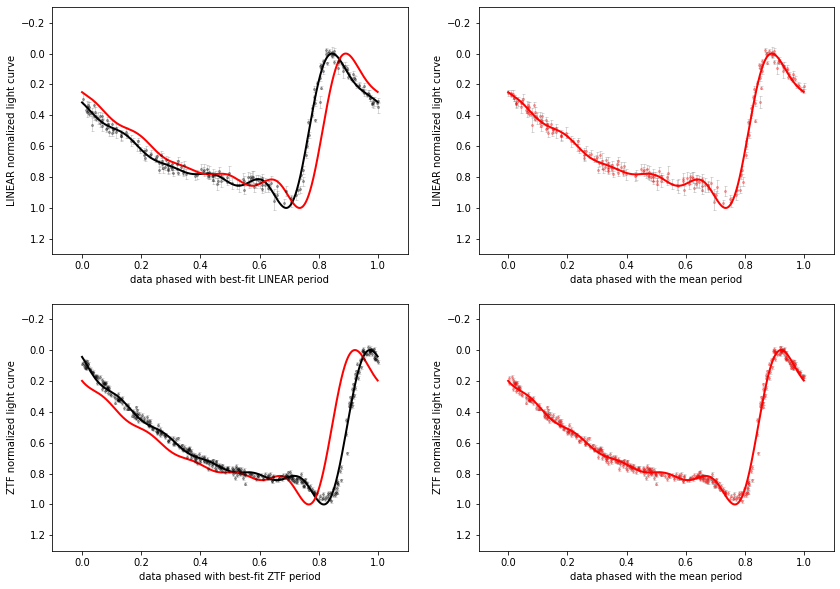

In [55]:
# id0 = '24107664'
# id0 = '10022663'
#id0 = '104455'
id0 = '18525697'
Pcomparison = {}
Pcomparison[id0] = compareLINEARvsZTFlightCurves(Lrrlyr, LINEARlightcurves, id0)

In [56]:
Pcomparison[id0]

{'LINEARid': '18525697',
 'Plinear': 0.5803202893371555,
 'Pztf': 0.5803197100455475,
 'Pratio': 0.9999990017726096,
 'NdataLINEAR': 211,
 'LPlin_rmsdmag': 0.029104825317095274,
 'LPlin_chi2dof': 3.6492559218194636,
 'LPlin_chi2dofR': 1.228701357931378,
 'LPmean_rmsdmag': 0.029307464464321527,
 'LPmean_chi2dof': 3.8905850508548108,
 'LPmean_chi2dofR': 1.2078797248315392,
 'Lmmax': 14.617220274562115,
 'Lampl': 0.9219187185215727,
 'NdataZTF': 414,
 'ZPztf_rmsdmag': 0.02308443017208216,
 'ZPztf_chi2dof': 5.38358620166978,
 'ZPztf_chi2dofR': 1.9327458059190175,
 'ZPmean_rmsdmag': 0.023448454577290587,
 'ZPmean_chi2dof': 5.400824746465192,
 'ZPmean_chi2dofR': 1.966024041884662,
 'Zmmax': 14.625823540913647,
 'Zampl': 0.9553223268327731}

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 95250
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.3138701783075068 Pztf= 0.31387647595881646 Pmean= 0.31387332713316163 Pratio= 1.0000200645099309
 LINEAR light curve analysis:
  Nlinear= 222 rms mag D-M: 0.16318469055747112 0.16537052176670766
      chi2dof: 0.8154371299515268 0.9053137012775344
       robust: 0.8566327192064899 0.8613413830829049
 ZTF light curve analysis:
  Nztf= 835 rms mag D-M: 0.04696985669003372 0.05520372376322278
      chi2dof: 2.8809558314792874 3.832166634173788
       robust: 1.3378515874232773 1.54662023149454


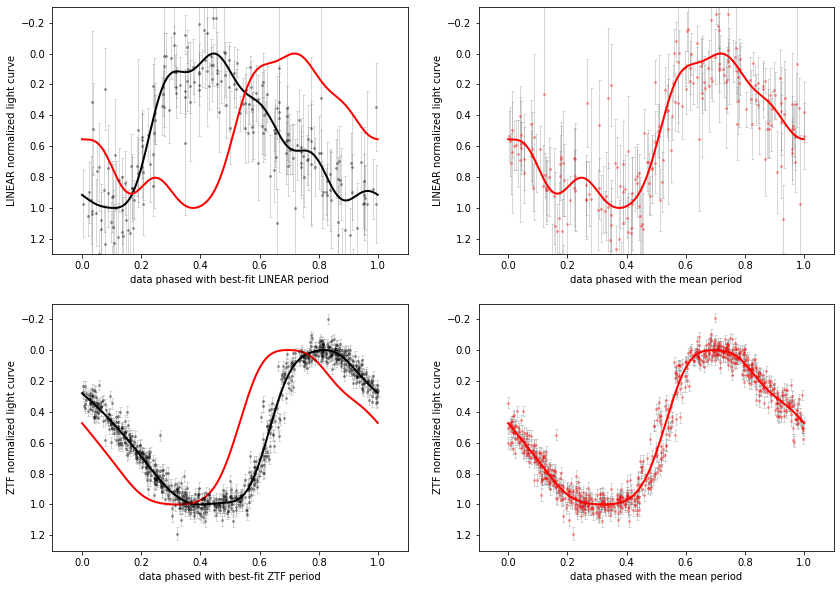

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 172382
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.45830941126942376 Pztf= 0.4583071829654734 Pmean= 0.4583082971174486 Pratio= 0.9999951379921608
 LINEAR light curve analysis:
  Nlinear= 227 rms mag D-M: 0.05855356458869973 0.060281655771175974
      chi2dof: 1.432600269515216 1.5770345660155087
       robust: 1.0927610705382325 1.0907826577154078
 ZTF light curve analysis:
  Nztf= 1378 rms mag D-M: 0.026879197026357365 0.027525967327840205
      chi2dof: 8.948270369879765 9.15711125099173
       robust: 2.318088078138074 2.4398214927364017


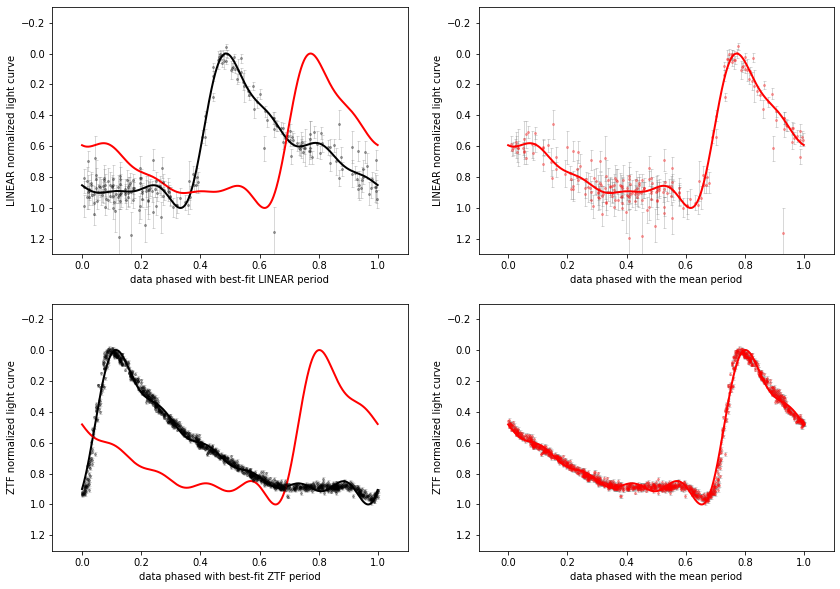

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 976746
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.6206737479263598 Pztf= 0.6206600267147662 Pmean= 0.620666887320563 Pratio= 0.9999778930369788
 LINEAR light curve analysis:
  Nlinear= 236 rms mag D-M: 0.0952284312924033 0.08944466203334597
      chi2dof: 3.8931667906314673 4.011681119180924
       robust: 1.5815107735011646 1.6055677086921065
 ZTF light curve analysis:
  Nztf= 635 rms mag D-M: 0.06449494995383372 0.061038423218092844
      chi2dof: 4.153800673821822 4.180696973016645
       robust: 2.00590370752423 1.887825804081585


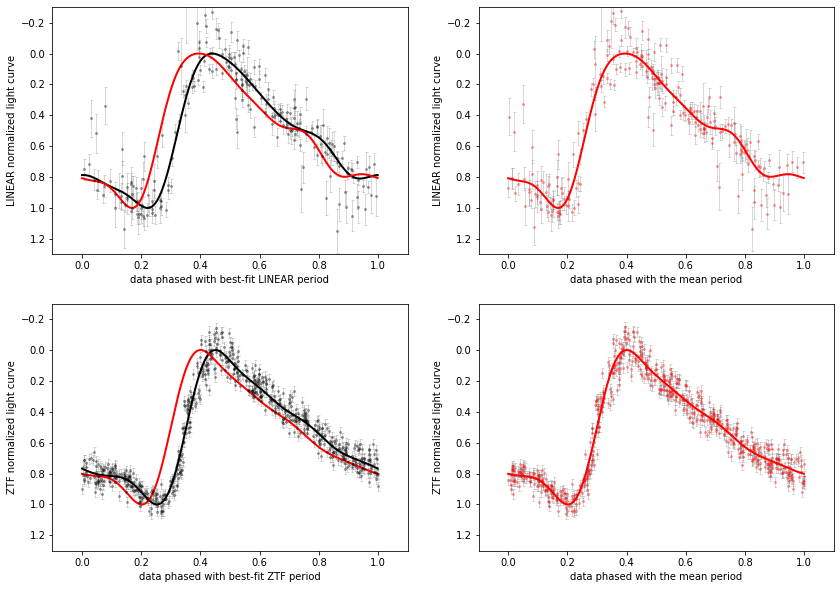

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 1092244
  computing LINEAR period...
  computing ZTF period...
Plinear= 0.6494953989763432 Pztf= 0.6495563372442702 Pmean= 0.6495258681103067 Pratio= 1.0000938240178807
 LINEAR light curve analysis:
  Nlinear= 590 rms mag D-M: 0.10542003650322856 0.15499013334563613
      chi2dof: 2.3229467132303916 5.0536866669627845
       robust: 1.1598096495044143 1.6818056063758116
 ZTF light curve analysis:
  Nztf= 295 rms mag D-M: 0.1276015915513962 0.15919980683924626
      chi2dof: 37.39356229335856 50.846722821676686
       robust: 4.0317938655205765 4.96060661855093


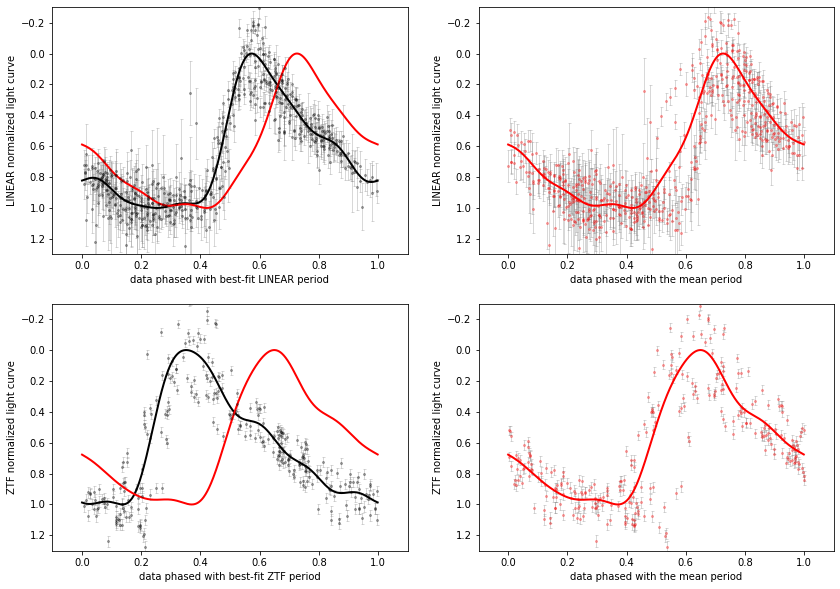

In [58]:
# let's check the four stars sent by Ema:
## Ema's stars;
# Prat=0.6-0.7:
# id0 = '95250'      # Pmean is ok 
# id0 = '172382'     # Pmean is ok, 1378 points in zr! 
# Prat=1.3-1.4:
# id0 = '976746'    # Pmean= 0.620667 fits well both datasets 
# id0 = '1092244'   # noisy ZTF phased curve: possibly Blazhko? 
emaStars = ['95250', '172382', '976746', '1092244']
for id0 in emaStars:
    Pcomparison[id0] = compareLINEARvsZTFlightCurves(Lrrlyr, LINEARlightcurves, id0)

In [59]:
for id0 in emaStars:
    print('LINEAR ID=', id0)
    print('    N data:  L=', Pcomparison[id0]['NdataLINEAR'], 'Z=', Pcomparison[id0]['NdataZTF'])
    print(' brightest m:  L=', Pcomparison[id0]['Lmmax'], 'Z=', Pcomparison[id0]['Zmmax'])
    print('      dm rms:  L=', Pcomparison[id0]['LPlin_rmsdmag'], 'Z=', Pcomparison[id0]['ZPztf_rmsdmag'])
    print('   best chi2:  L=', Pcomparison[id0]['LPlin_chi2dofR'], 'Z=', Pcomparison[id0]['ZPztf_chi2dofR'])
    print('   mean chi2:  L=', Pcomparison[id0]['LPmean_chi2dofR'], 'Z=', Pcomparison[id0]['ZPmean_chi2dofR'])
    print('   amplitude:  L=', Pcomparison[id0]['Lampl'], 'Z=', Pcomparison[id0]['Zampl'])
    print('     P ratio: ', Pcomparison[id0]['Pratio'], 'Plinear:', Pcomparison[id0]['Plinear'])

LINEAR ID= 95250
    N data:  L= 222 Z= 835
 brightest m:  L= 16.70919475883034 Z= 16.68014308959315
      dm rms:  L= 0.16318469055747112 Z= 0.04696985669003372
   best chi2:  L= 0.8566327192064899 Z= 1.3378515874232773
   mean chi2:  L= 0.8613413830829049 Z= 1.54662023149454
   amplitude:  L= 0.48365653449550905 Z= 0.4616338580989101
     P ratio:  1.0000200645099309 Plinear: 0.3138701783075068
LINEAR ID= 172382
    N data:  L= 227 Z= 1378
 brightest m:  L= 15.48701329497685 Z= 15.523514391724683
      dm rms:  L= 0.05855356458869973 Z= 0.026879197026357365
   best chi2:  L= 1.0927610705382325 Z= 2.318088078138074
   mean chi2:  L= 1.0907826577154078 Z= 2.4398214927364017
   amplitude:  L= 1.1588196950882352 Z= 1.0972849581190385
     P ratio:  0.9999951379921608 Plinear: 0.45830941126942376
LINEAR ID= 976746
    N data:  L= 236 Z= 635
 brightest m:  L= 14.966708947108799 Z= 14.8453116214796
      dm rms:  L= 0.0952284312924033 Z= 0.06449494995383372
   best chi2:  L= 1.5815107735011

In [52]:
Lab = Lrrlyr[(Lrrlyr['LCtype']==1)]
len(Lab)

2144